# Defining the Data Analysis Workflow and Understanding the Model and Data

In [25]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import sys
import os
sys.path.append(os.path.join(os.path.abspath('..')))

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import requests
from io import StringIO

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Loding important lib
import src.data_loading as data_loading

In [4]:
# Reload the module
importlib.reload(data_loading)

<module 'src.data_loading' from 'c:\\Users\\Hp\\Desktop\\Kifiya\\week10\\BrentOilPrice-EventAnalysis\\src\\data_loading.py'>

In [5]:
from src.data_loading import data_loading, query_data, df

In [6]:
# Load the data into database
data_loading(df)

Data successfully loaded into table: BrentOilPrices


In [7]:
# Query the data from database
result_df = query_data
if result_df is not None:
    print("Data from the database is loaded")

Data from the database is loaded


In [8]:
# View the head of the dataset
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [9]:
# Shape of the dataset
df.shape

(9011, 2)

we have 9011 rows of data with 2 features.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


The data set have 2 columns Date is object and Price with float.

In [18]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

This confirms that there are not missing values in the dataset.

In [22]:
# Descriptive statistics
df.Price.describe()

count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

In [26]:
# Check how symetrical the price feature is
df.skew(numeric_only=True)

Price    0.765305
dtype: float64

The feature price is moderately skewed in a positive direction.

In [27]:
# Checking outliers
df.kurtosis(numeric_only=True)

Price   -0.61044
dtype: float64

On price features -0.61 Kurtosis value indicates lower lighter tails this assures the distribution has fewer extreme(outliers) values.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

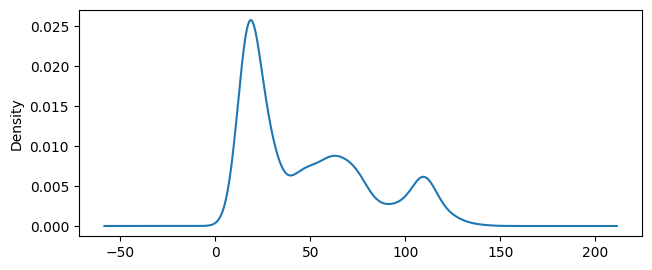

In [51]:
# Density plot
df['Price'].plot(kind='density', subplots=True, layout=(3, 2), sharex=False, figsize=(16, 10))

Price distibution shows that there are more data are from 0 to 50 price range.

<Axes: xlabel='Price'>

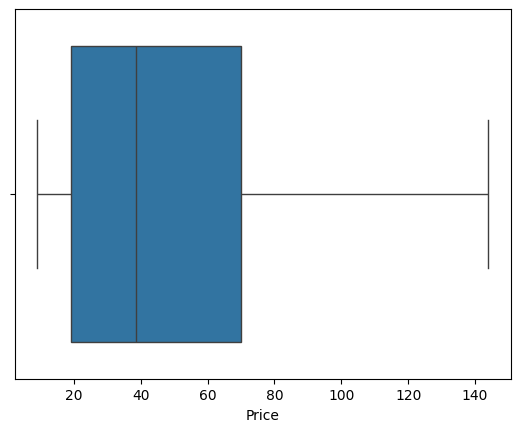

In [44]:
# Distribution of Price data 
sns.boxplot(x='Price', data=df)

## Step 2: Exploratory Data Analysis (EDA)
### 2.1 Plot Time Series of Brent Oil Prices

##### Step 1: Ensure the Index is a DatetimeIndex with Frequency

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Ensure the index is a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Ensure the index is a DatetimeIndex with daily frequency
df = df.asfreq('D')

# Sort the data by date
df = df.sort_values('Date')

Step 2: Check for and Handle Missing Values

In [12]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

# Display the first few rows after dropping missing values
print(df.head())

Price    3952
dtype: int64
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


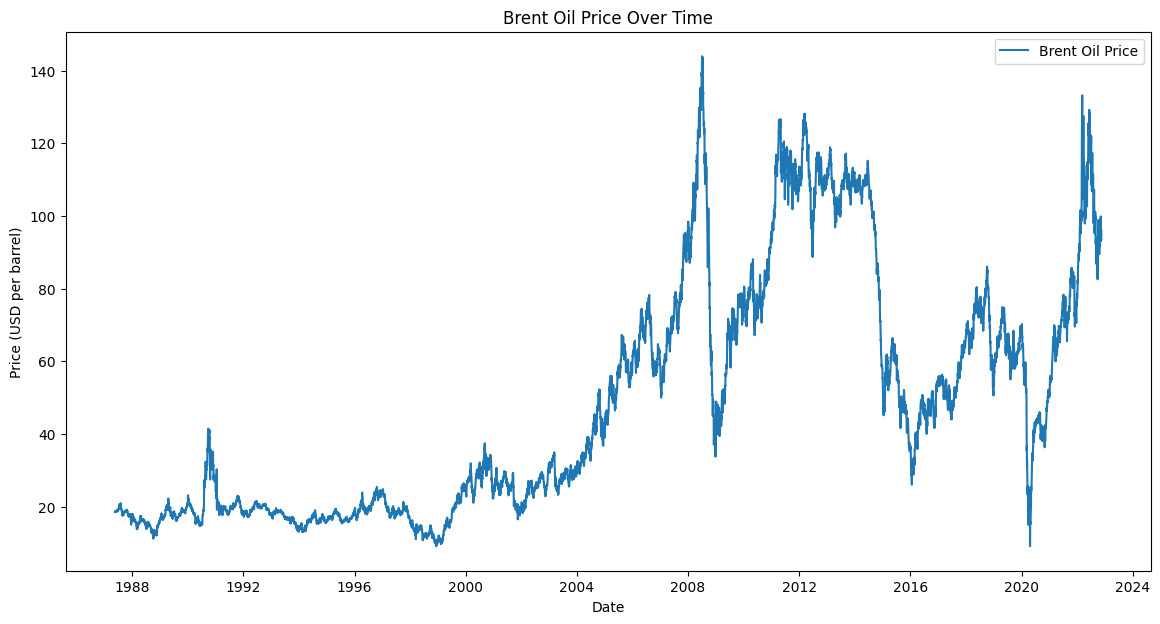

In [13]:
# Convert to daily frequency
plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

### 2.2 Add Event Markers

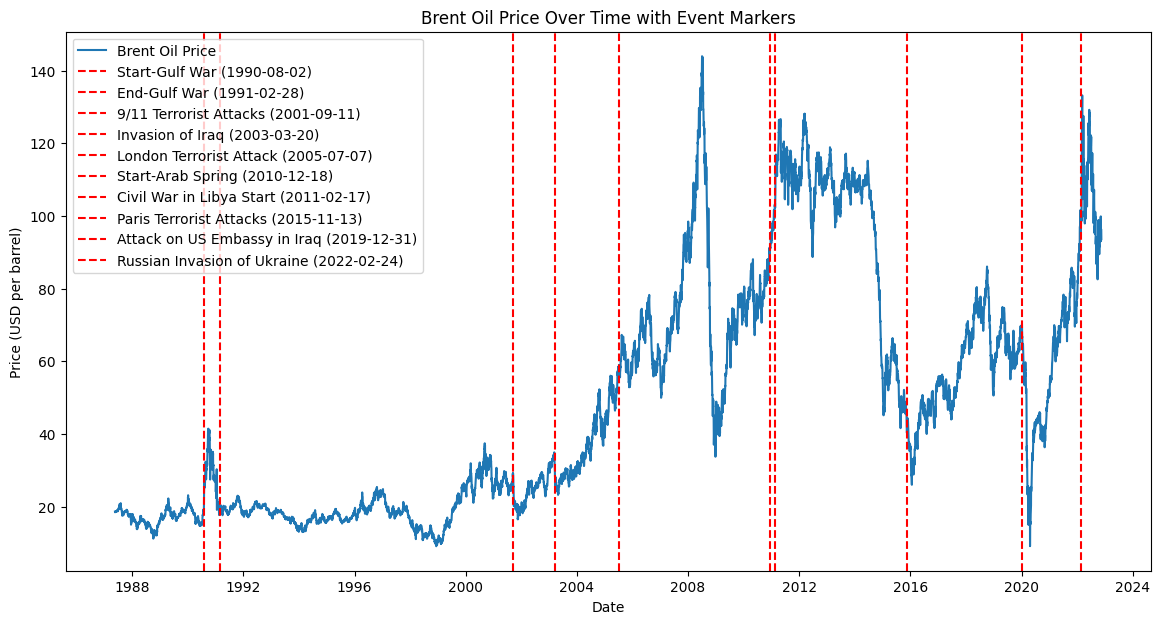

In [14]:
# Example: Marking significant political events
significant_events = {
    '1990-08-02': 'Start-Gulf War',
    '1991-02-28': 'End-Gulf War',
    '2001-09-11': '9/11 Terrorist Attacks',
    '2003-03-20': 'Invasion of Iraq',
    '2005-07-07': 'London Terrorist Attack',
    '2010-12-18': 'Start-Arab Spring',
    '2011-02-17': 'Civil War in Libya Start',
    '2015-11-13': 'Paris Terrorist Attacks',
    '2019-12-31': 'Attack on US Embassy in Iraq',
    '2022-02-24': 'Russian Invasion of Ukraine',
}

plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Brent Oil Price')
for date, event in significant_events.items():
    plt.axvline(pd.to_datetime(date), color='r', linestyle='--', label=f'{event} ({date})')
plt.title('Brent Oil Price Over Time with Event Markers')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend(loc='best')
plt.show()

### Step 3: Model Selection and Development

#### 3.1 Stationarity Test (ADF Test)

In [15]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

test_stationarity(df['Price'])

ADF Statistic: -1.993856
p-value: 0.289274
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### 3.2 Differencing to Achieve Stationarity

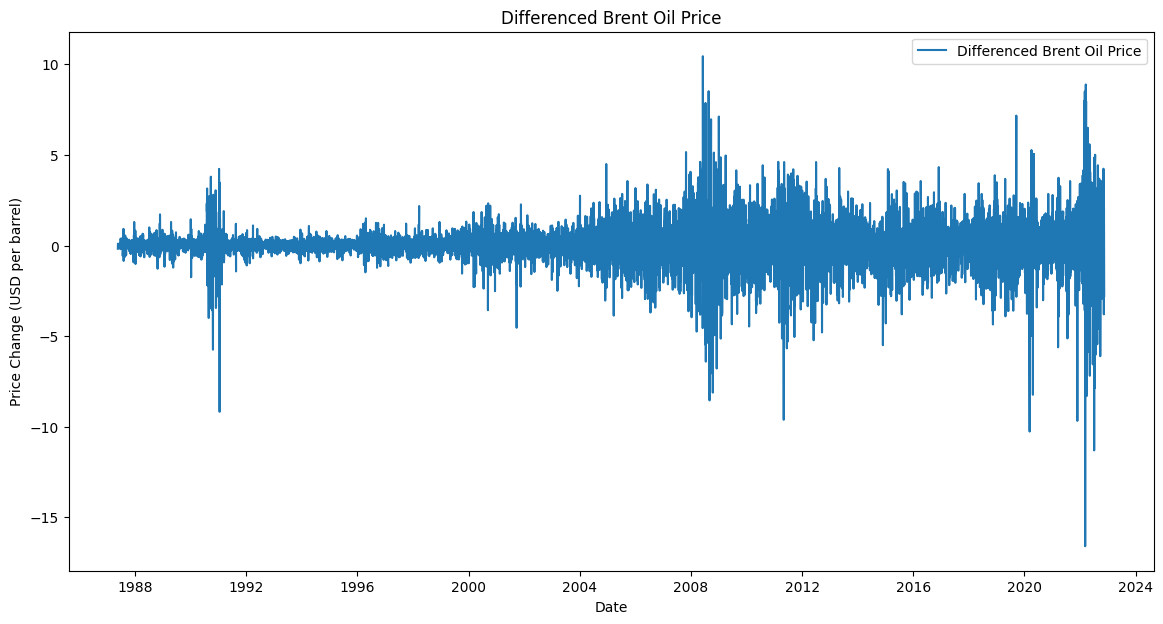

ADF Statistic: -15.529368
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [16]:
# Differencing
diff_data = df['Price'].diff().dropna()

# Plot differenced data
plt.figure(figsize=(14, 7))
plt.plot(diff_data, label='Differenced Brent Oil Price')
plt.title('Differenced Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price Change (USD per barrel)')
plt.legend()
plt.show()

# Test stationarity of differenced data
test_stationarity(diff_data)

#### 3.3 Autocorrelation and Partial Autocorrelation Plots

<Figure size 1400x700 with 0 Axes>

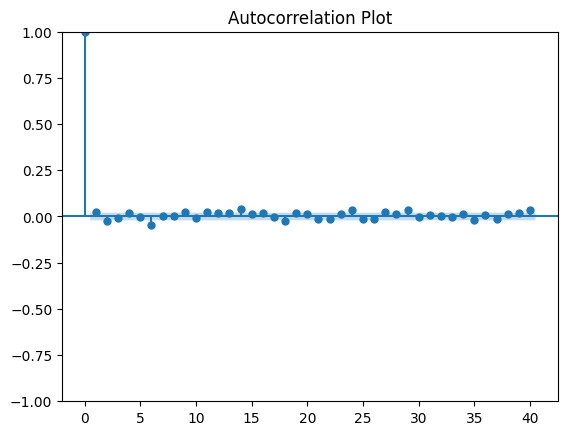

<Figure size 1400x700 with 0 Axes>

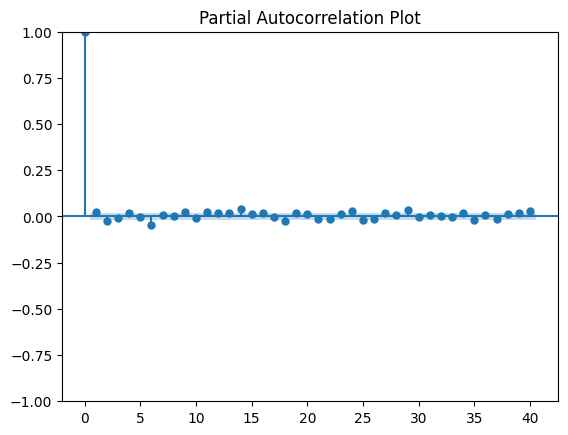

In [17]:
plt.figure(figsize=(14, 7))
plot_acf(diff_data, lags=40)
plt.title('Autocorrelation Plot')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(diff_data, lags=40)
plt.title('Partial Autocorrelation Plot')
plt.show()

#### 3.4 ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Sat, 02 Nov 2024   AIC                          29093.226
Time:                        03:11:01   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

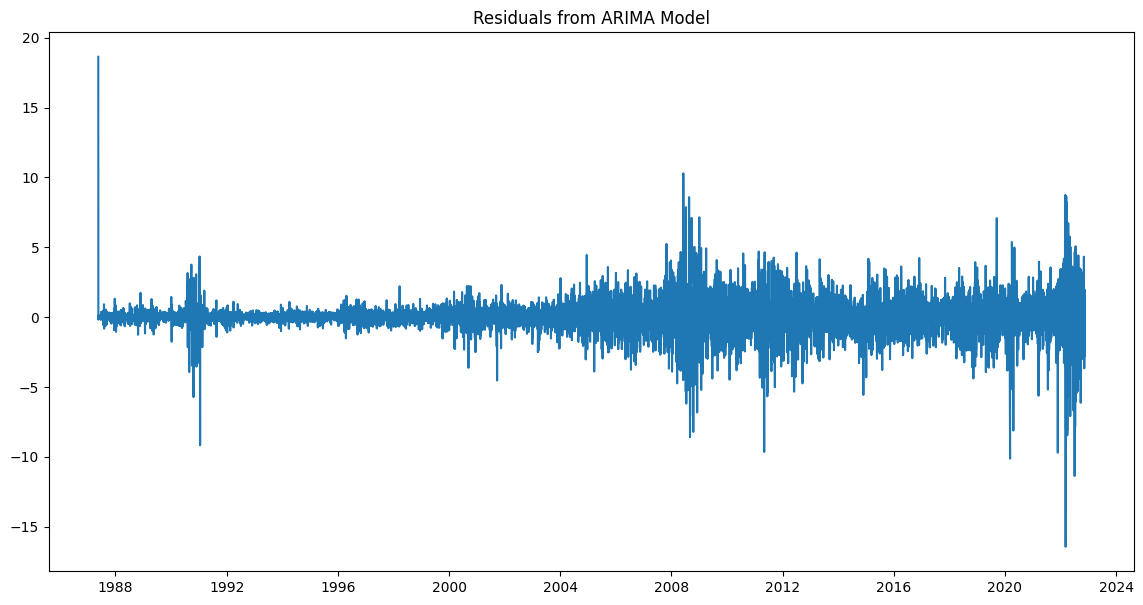

In [18]:
# Fit ARIMA model
model = ARIMA(df['Price'], order=(5, 1, 0))
model_fit = model.fit()

# Summary the model
print(model_fit.summary())

# Plot the residuals 
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

### Step 4: Model Evaluation

#### 4.1 Split Data into Training and Testing Sets

In [19]:
# Split data into training and testing sets
train_data = df[:'2020-01-01']
test_data = df['2020-01-01':]

# Display the first few rows of the training and testing sets
print("Training Data:")
print(train_data.head())
print("\nTesting Data:")
print(test_data.head())

Training Data:
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63

Testing Data:
            Price
Date             
2020-01-01  67.77
2020-01-02  67.05
2020-01-03  69.08
2020-01-06  70.25
2020-01-07  68.74


#### 4.2 Visualize the Split

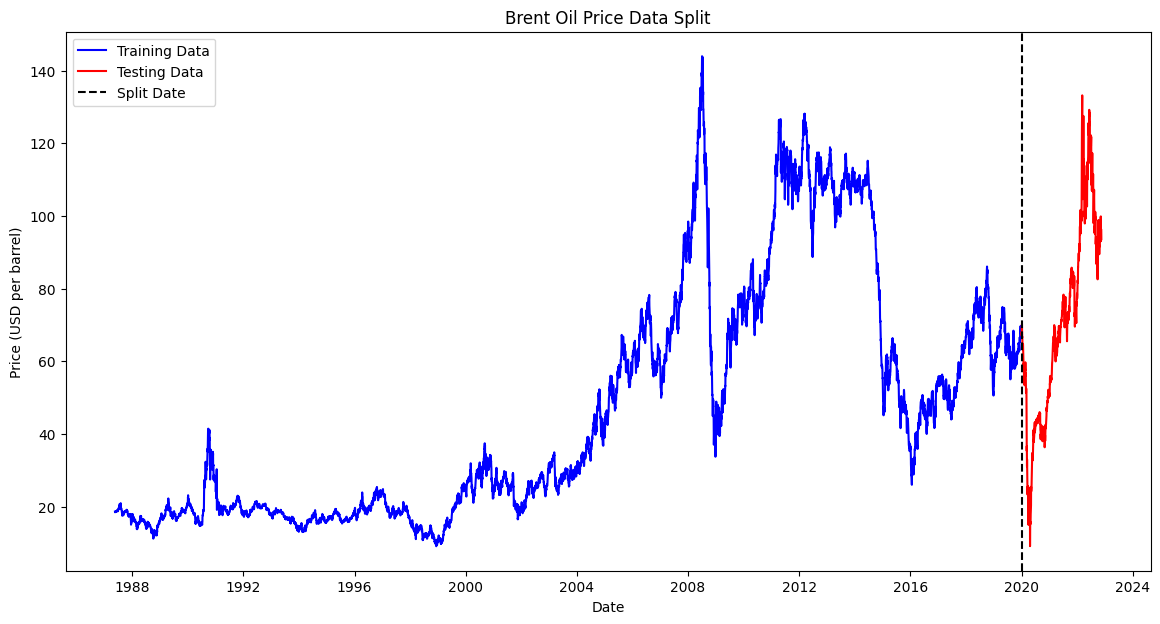

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(train_data['Price'], label='Training Data', color='blue')
plt.plot(test_data['Price'], label='Testing Data', color='red')
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle='--', label='Split Date')
plt.title('Brent Oil Price Data Split')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

#### 4.3 Fit ARIMA Model on Training Data

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8283
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12347.840
Date:                Sat, 02 Nov 2024   AIC                          24707.681
Time:                        03:11:15   BIC                          24749.812
Sample:                             0   HQIC                         24722.076
                               - 8283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0286      0.007      3.921      0.000       0.014       0.043
ar.L2         -0.0102      0.007     -1.509      0.131      -0.023       0.003
ar.L3         -0.0081      0.007     -1.247      0.2

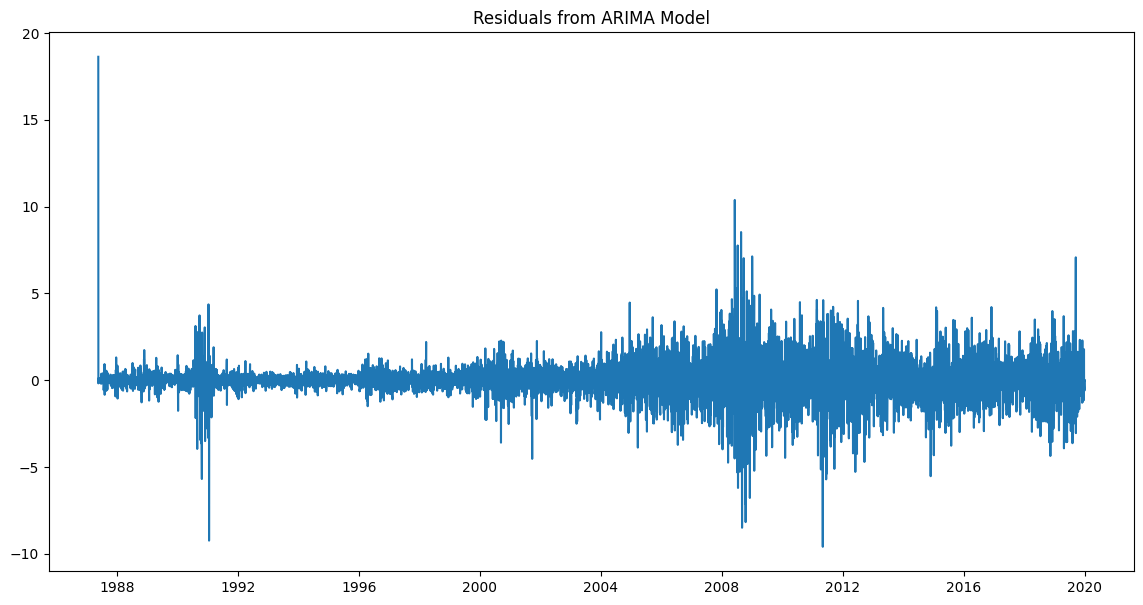

In [21]:
# Fit ARIMA model on training data
arima_model = ARIMA(train_data['Price'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Summary of the model
print(arima_fit.summary())

# Plot residuals
residuals = pd.DataFrame(arima_fit.resid)
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

#### 4.4 Forecast on Test Data

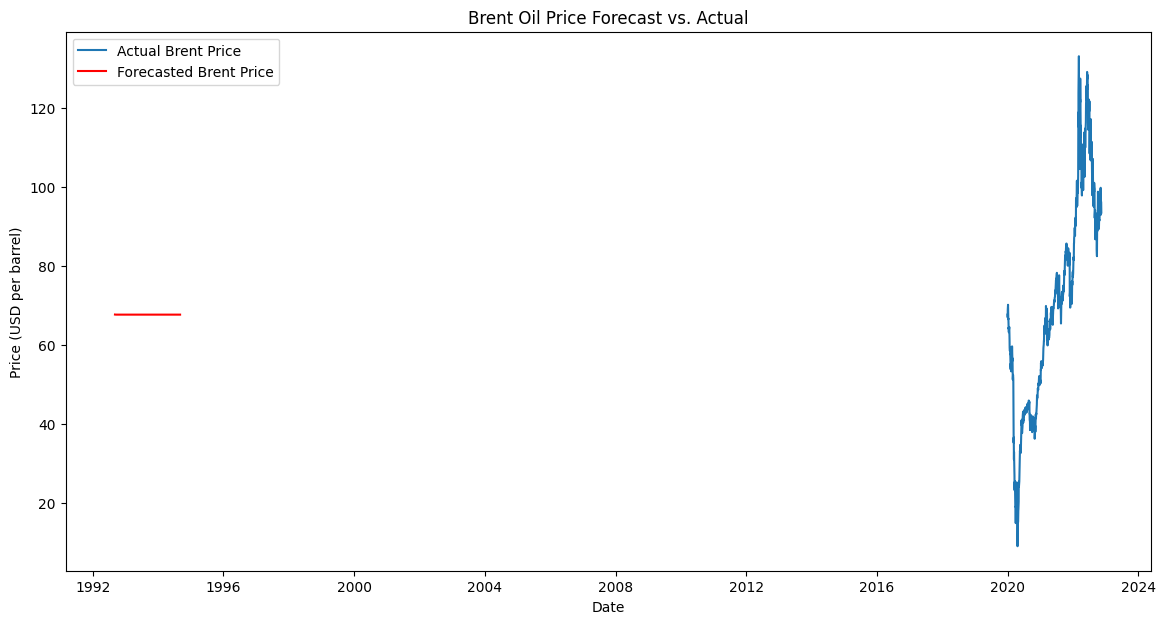

In [22]:
# Forecast on test data
forecast = arima_fit.forecast(steps=len(test_data))

# Plot actual vs. forecasted
plt.figure(figsize=(14, 7))
plt.plot(test_data['Price'], label='Actual Brent Price')
plt.plot(forecast, label='Forecasted Brent Price', color='red')
plt.title('Brent Oil Price Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(test_data['Price'], forecast)
mae = mean_absolute_error(test_data['Price'], forecast)
r2 = r2_score(test_data['Price'], forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

MSE: 738.4511328465483
MAE: 22.242137748490876
R-squared: -0.011106729883842092


### Step 5: Insight Generation and Reporting


#### 5.1 Event Impact Analysis

In [24]:
# Calculate price changes around significant events
event_impact = {}
for date, event in significant_events.items():
    event_date = pd.to_datetime(date)
    before_event = df.loc[event_date - pd.DateOffset(days=30):event_date]['Price']
    after_event = df.loc[event_date:event_date + pd.DateOffset(days=30)]['Price']
    event_impact[event] = {
        'Before Event Mean': before_event.mean(),
        'After Event Mean': after_event.mean(),
        'Price Change': after_event.mean() - before_event.mean()
    }

# Display event impact
event_impact_df = pd.DataFrame(event_impact).T
print(event_impact_df)

                              Before Event Mean  After Event Mean  \
Start-Gulf War                        17.586957         27.496364   
End-Gulf War                          19.700870         19.102381   
9/11 Terrorist Attacks                26.238182         23.525652   
Invasion of Iraq                      32.826522         26.056364   
London Terrorist Attack               55.515652         58.191818   
Start-Arab Spring                     87.961429         94.552105   
Civil War in Libya Start              99.373913        112.181429   
Paris Terrorist Attacks               46.730000         41.610952   
Attack on US Embassy in Iraq          67.310000         64.259565   
Russian Invasion of Ukraine           95.485652        115.881818   

                              Price Change  
Start-Gulf War                    9.909407  
End-Gulf War                     -0.598489  
9/11 Terrorist Attacks           -2.712530  
Invasion of Iraq                 -6.770158  
London Terroris